# Hoe kut zijn RE’s?

In [75]:
import plot
import utils
from datetime import datetime
import geoutils
import statistics

DATETIME_FORMAT = "%Y-%m-%dT%H:%M:%S%z"

In [76]:
data = utils.read_json("data.json")

def line_with_station_info(line, station):
    for key in station["params"]:
        line[f"station_{key}"] = station["params"][key]
    return line


lines = [line_with_station_info(l, station) for station in data.values() for l in station["lines"]]
" | ".join(lines[0].keys())


'tripId | direction | line_name | line_id | admin | type | type_name | operator_name | operator_id | stops | station_key | station_station_id | station_name | station_region | station_country'

In [77]:
def calculate_diff_in_minutes(timestamp1, timestamp2):
    return (datetime.strptime(timestamp2, DATETIME_FORMAT) - datetime.strptime(timestamp1, DATETIME_FORMAT)).total_seconds() / 60

for line in lines:
    def create_segment_object(s1, s2):
        departure = s1["departure"] if s1["departure"] != None else s1["arrival"]
        arrival = s2["arrival"] if s2["arrival"] != None else s2["departure"]
        time = calculate_diff_in_minutes(departure, arrival)
        dist = geoutils.distance(s1["location"], s2["location"]) * 1.1
        return {
            "time": time,
            "dist": dist,
            "speed": 60 * dist / time
        }

    line["segments"] = [create_segment_object(line["stops"][i - 1], s2) for (i, s2) in enumerate(line["stops"]) if i > 0]

    for stop in line["stops"]:
        arrival = stop["arrival"]
        departure = stop["departure"]

        if arrival != None and departure != None:
            stop["time"] = calculate_diff_in_minutes(arrival, departure)
        else: 
            stop["time"] = 0
    
    line["total_dist"] = sum([seg["dist"] for seg in line["segments"]])
    line["total_time"] = sum([st["time"] for st in line["stops"]]) + sum([seg["time"] for seg in line["segments"]])
    line["avg_speed"] = 60 * line["total_dist"] / line["total_time"] if line["total_time"] > 0 else 0
    line["median_time_between_stops"] = statistics.median([seg["time"] for seg in line["segments"]]) if len(line["segments"]) > 0 else 0

lines = [l for l in lines if l["total_time"] > 0]

In [78]:
german_lines = [l for l in lines if l["station_country"] == "D"]
dutch_lines = [l for l in lines if l["station_country"] == "NL"]

german_ic = [l for l in german_lines if l["type"] == "national"]
german_re = [l for l in german_lines if l["type_name"] == "RE"]
dutch_ic = [l for l in dutch_lines if l["type"] == "national"]
dutch_re = [l for l in dutch_lines if l["type"] == "regional"]

## Departures per station

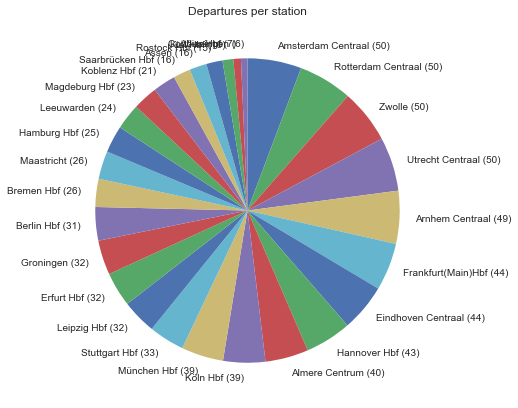

In [79]:
plot.pie(lines, "station_name", count_y=True, sort_by="y", display_absolute_value=True, title="Departures per station", save_to="img/deps_per_station")

## Travel time

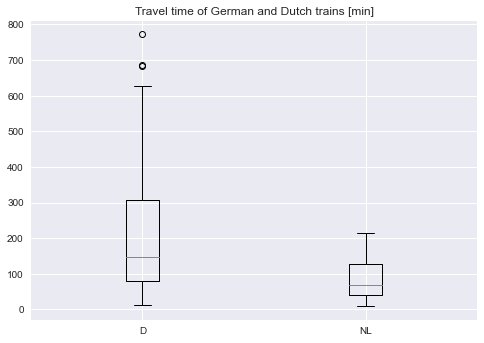

In [80]:
plot.box_plot([german_lines, dutch_lines], x="total_time", title="Travel time of German and Dutch trains [min]", x_tick_labels=["D", "NL"], save_to="img/time_dnl.png")

In [81]:
def print_top_ten(lines_arr, key, reverse=False):
    for (i, l) in enumerate(sorted(lines_arr, key=lambda l: l[key], reverse=reverse)[:10]):
        print(f"{i+1}: {l['line_name']}: {l['stops'][0]['name']}–{l['stops'][-1]['name']} ({l[key]})")

def print_german_and_dutch_top_ten(key, reverse=False):
    print(f"Top 10 German lines ({key}, reverse={reverse}):")
    print_top_ten(german_lines, key=key, reverse=reverse)
    print()

    print(f"Top 10 Dutch lines ({key}, reverse={reverse}):")
    print_top_ten(dutch_lines, key=key, reverse=reverse)

In [82]:
print_german_and_dutch_top_ten("total_time")

Top 10 German lines (total_time, reverse=False):
1: RB 76: Kiel Hbf–Kiel-Oppendorf (11.0)
2: S 5: Hannover Hbf–Hannover Flughafen (14.0)
3: RB 46: Cottbus Hbf–Forst(Lausitz) (18.0)
4: S 1: Rostock Hbf–Warnemünde (21.0)
5: RE 72: Kiel Hbf–Eckernförde (26.0)
6: HLB RB58: Frankfurt(Main)Hbf–Hanau Hbf (27.0)
7: RB 12: Rostock Hbf–Graal-Müritz (27.0)
8: S 4: Hannover Hbf–Bennemühlen (27.0)
9: S 5: Bietigheim-Bissingen–Stuttgart Schwabstr. (31.0)
10: RB 36: Magdeburg Hbf–Haldensleben (31.0)

Top 10 Dutch lines (total_time, reverse=False):
1: VIA RE19: Arnhem Centraal–Zevenaar (9.0)
2: 5382: Maastricht–Eijsden (10.0)
3: 5383: Maastricht–Eijsden (10.0)
4: RE 8529: Zwolle–Kampen(NL) (11.0)
5: RE 8531: Zwolle–Kampen(NL) (11.0)
6: RE 8533: Zwolle–Kampen(NL) (11.0)
7: RE 8535: Zwolle–Kampen(NL) (11.0)
8: RE 7532: Arnhem Centraal–Ede-Wageningen (15.0)
9: RE 7534: Arnhem Centraal–Ede-Wageningen (15.0)
10: RE 7536: Arnhem Centraal–Ede-Wageningen (15.0)


In [83]:
print_german_and_dutch_top_ten("total_time", reverse=True)

Top 10 German lines (total_time, reverse=True):
1: IC 2216: Offenburg–Greifswald (772.0)
2: IC 2217: Greifswald–Stuttgart Hbf (686.0)
3: ICE 618: München Hbf–Kiel Hbf (682.0)
4: ICE 1671: Ostseebad Binz–Karlsruhe Hbf (626.0)
5: ICE 1020: Regensburg Hbf–Hamburg-Altona (583.0)
6: ICE 1577: Stralsund Hbf–Karlsruhe Hbf (570.0)
7: IC 2212: Koblenz Hbf–Ostseebad Binz (563.0)
8: ICE 692: München Hbf–Berlin Ostbahnhof (550.0)
9: ICE 599: Berlin Ostbahnhof–München Hbf (548.0)
10: ICE 616: München Hbf–Hamburg-Altona (545.0)

Top 10 Dutch lines (total_time, reverse=True):
1: IC 3928: Heerlen–Enkhuizen (214.0)
2: IC 3930: Heerlen–Enkhuizen (214.0)
3: IC 3934: Heerlen–Enkhuizen (214.0)
4: IC 3936: Heerlen–Enkhuizen (214.0)
5: IC 3938: Heerlen–Enkhuizen (214.0)
6: IC 3940: Heerlen–Enkhuizen (214.0)
7: IC 3930: Heerlen–Enkhuizen (214.0)
8: IC 3935: Enkhuizen–Heerlen (212.0)
9: IC 3937: Enkhuizen–Heerlen (212.0)
10: IC 3929: Enkhuizen–Heerlen (212.0)


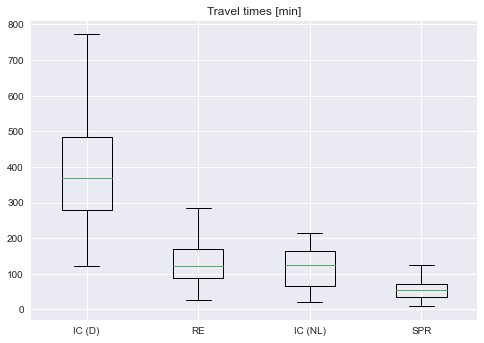

In [84]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="total_time", title="Travel times [min]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/time_categs.png")

### Median travel time between stops

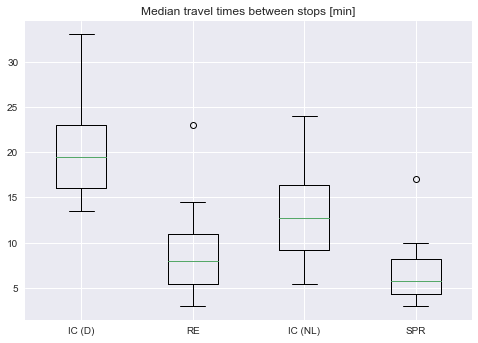

In [85]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="median_time_between_stops", title="Median travel times between stops [min]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/time_between_categs.png")

## Distance

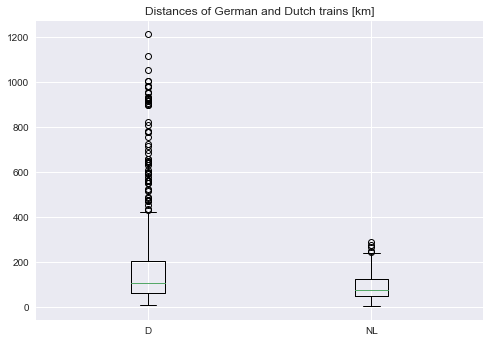

In [86]:
plot.box_plot([german_lines, dutch_lines], x="total_dist", title="Distances of German and Dutch trains [km]", x_tick_labels=["D", "NL"], save_to="img/dist_dnl.png")

In [87]:
print_german_and_dutch_top_ten("total_dist")

Top 10 German lines (total_dist, reverse=False):
1: RB 76: Kiel Hbf–Kiel-Oppendorf (6.407583661118373)
2: S 5: Hannover Hbf–Hannover Flughafen (11.972057293720242)
3: S 1: Rostock Hbf–Warnemünde (14.157289568602765)
4: S 1: Leipzig-Stötteritz–Leipzig Miltitzer Allee (22.10916517549659)
5: S 1: Leipzig Miltitzer Allee–Leipzig-Stötteritz (22.10916517549659)
6: S 4: Markkleeberg-Gaschwitz–Taucha(Leipzig) (22.65758978557418)
7: HLB RB58: Frankfurt(Main)Hbf–Hanau Hbf (23.524461302330852)
8: RB 46: Cottbus Hbf–Forst(Lausitz) (23.897062939360346)
9: HLB RB12: Frankfurt(Main)Hbf–Königstein(Taunus) (24.16534614589039)
10: RB 12: Rostock Hbf–Graal-Müritz (25.424638694437096)

Top 10 Dutch lines (total_dist, reverse=False):
1: RE 28305: Utrecht Centraal–Utrecht Maliebaan (1.6403711520191462)
2: 5382: Maastricht–Eijsden (9.801908240855745)
3: 5383: Maastricht–Eijsden (9.801908240855745)
4: RE 8529: Zwolle–Kampen(NL) (14.280422235768993)
5: RE 8531: Zwolle–Kampen(NL) (14.280422235768993)
6: RE 8533

In [88]:
print_german_and_dutch_top_ten("total_dist", reverse=True)

Top 10 German lines (total_dist, reverse=True):
1: IC 2216: Offenburg–Greifswald (1211.753907404297)
2: ICE 618: München Hbf–Kiel Hbf (1116.0104866518304)
3: IC 2217: Greifswald–Stuttgart Hbf (1053.1679411325722)
4: ICE 519: Hamburg-Altona–München Hbf (1003.6611483681284)
5: ICE 614: München Hbf–Hamburg-Altona (1003.6611483681282)
6: ICE 616: München Hbf–Hamburg-Altona (1003.6611483681282)
7: ICE 692: München Hbf–Berlin Ostbahnhof (981.1370765787772)
8: ICE 599: Berlin Ostbahnhof–München Hbf (981.137076578777)
9: ICE 598: München Hbf–Berlin Hbf (tief) (975.9012709099153)
10: ICE 1671: Ostseebad Binz–Karlsruhe Hbf (953.3029301905751)

Top 10 Dutch lines (total_dist, reverse=True):
1: IC 831: Schagen–Maastricht (285.8662481428388)
2: IC 3935: Enkhuizen–Heerlen (276.303914837685)
3: IC 3928: Heerlen–Enkhuizen (276.303914837685)
4: IC 3937: Enkhuizen–Heerlen (276.303914837685)
5: IC 3930: Heerlen–Enkhuizen (276.303914837685)
6: IC 3929: Enkhuizen–Heerlen (276.303914837685)
7: IC 3934: Heer

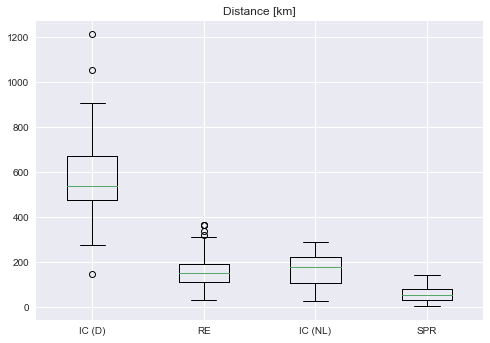

In [89]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="total_dist", title="Distance [km]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/dist_categs.png")

## Speed

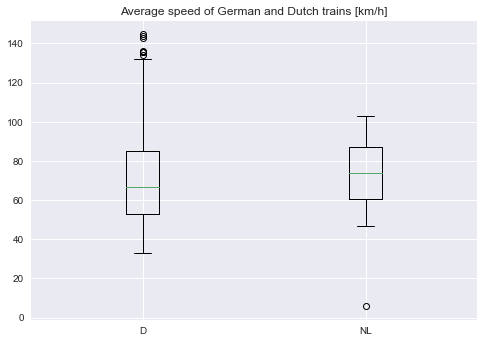

In [90]:
plot.box_plot([german_lines, dutch_lines], x="avg_speed", title="Average speed of German and Dutch trains [km/h]", x_tick_labels=["D", "NL"], save_to="img/speed_dnl.png")

In [91]:
print_german_and_dutch_top_ten("avg_speed")

Top 10 German lines (avg_speed, reverse=False):
1: S 1: Hamburg Airport–Hamburg-Blankenese (33.02060894578249)
2: S 1: Leipzig Miltitzer Allee–Leipzig-Stötteritz (33.163747763244885)
3: S 1: Leipzig-Stötteritz–Leipzig Miltitzer Allee (34.014100269994756)
4: S 5: Berlin Westkreuz–Berlin-Mahlsdorf (S) (34.13504306065811)
5: S 1: Wedel(Holst)–Hamburg Airport (34.77056393947703)
6: S 1: Hamburg Airport–Wedel(Holst) (34.770563939477036)
7: S 5: Berlin-Mahlsdorf (S)–Berlin Westkreuz (34.877109214150686)
8: RB 76: Kiel Hbf–Kiel-Oppendorf (34.95045633337295)
9: S 1: Wedel(Holst)–Hamburg-Poppenbüttel (34.9536233918693)
10: S 9: Flughafen BER - Terminal 1-2 (S-Bahn)–Berlin-Spandau (S) (38.53499689375833)

Top 10 Dutch lines (avg_speed, reverse=False):
1: RE 28305: Utrecht Centraal–Utrecht Maliebaan (5.789545242420516)
2: 32025: Heerlen–Maastricht Randwyck (46.59148027233017)
3: 32027: Heerlen–Maastricht Randwyck (46.59148027233017)
4: 32029: Heerlen–Maastricht Randwyck (46.59148027233017)
5: 320

In [92]:
print_german_and_dutch_top_ten("avg_speed", reverse=True)

Top 10 German lines (avg_speed, reverse=True):
1: ICE 1008: München Hbf–Hamburg-Altona (144.59141720369314)
2: ICE 1005: Hamburg-Altona–München Hbf (143.88508150158933)
3: ICE 1006: München Hbf–Hamburg-Altona (142.67375915059375)
4: ICE 602: München Hbf–Hamburg-Altona (136.1974585009146)
5: ICE 505: Hamburg-Altona–München Hbf (135.86033607888263)
6: ICE 1600: München Hbf–Hamburg-Altona (135.66930688342362)
7: ICE 507: Hamburg-Altona–München Hbf (135.52487845893475)
8: ICE 509: Hamburg-Altona–München Hbf (135.52487845893475)
9: ICE 703: Hamburg-Altona–München Hbf (134.15502393543562)
10: ICE 1010: Stuttgart Hbf–Dortmund Hbf (132.1182087835306)

Top 10 Dutch lines (avg_speed, reverse=True):
1: 37327: Groningen–Leeuwarden (102.78225716482208)
2: 37331: Groningen–Leeuwarden (102.78225716482208)
3: 37338: Leeuwarden–Groningen (102.78225716482208)
4: 37342: Leeuwarden–Groningen (102.78225716482208)
5: 37329: Groningen–Leeuwarden (102.57127017215218)
6: 37333: Groningen–Leeuwarden (102.571270

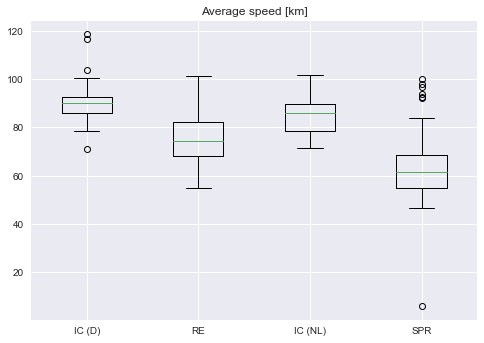

In [93]:
plot.box_plot([german_ic, german_re, dutch_ic, dutch_re], x="avg_speed", title="Average speed [km]", x_tick_labels=["IC (D)", "RE", "IC (NL)", "SPR"], save_to="img/speed_categs.png")